# Wind Power forecasting for the day-ahead energy market - Data Challenge
by Compagnie Nationale du Rhône, ENS Paris & Collège de France

<p align="center"><img src="https://cap.img.pmdstatic.net/fit/http.3A.2F.2Fprd2-bone-image.2Es3-website-eu-west-1.2Eamazonaws.2Ecom.2Fcap.2F2019.2F10.2F04.2Fea495374-9115-4be7-a91a-e9bc5b305b0b.2Ejpeg/768x432/background-color/ffffff/focus-point/992%2C1086/quality/70/dangereuses-pour-la-sante-peu-ecolo-faut-il-en-finir-avec-les-eoliennes-1352031.jpg" width="600"/></p>

Challenge website: https://challengedata.ens.fr/participants/challenges/34/

The objective of this challenge is to **design and train an ML/DL model to predict the hourly electrical production** of six independent wind farms owned by CNR for the day ahead, using multiple Numerical Weather Predictions (NWP) models. This is a **supervised learning problem** based on **multivariate time series**.

This notebook is **fully compatible with Google Colab**, feel free to try it yourself!
https://colab.research.google.com/github/qcha41/wind-power-forecasting-challenge/blob/master/notebook.ipynb

## Notebook setup

First of all, let's import the required libraries and configure the notebook.

In [ ]:
# Google Colab configuration
!git clone https://github.com/qcha41/wind-power-forecasting-challenge.git
!pip install urllib3==1.25.4 folium==0.2.1 boto3 mlflow mpld3 --quiet
%cd wind-power-forecasting-challenge

In [1]:
# Load and configure libraires
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import core
import mlflow, mlflow.tensorflow
import mpld3
import matplotlib.pyplot as plt 
import seaborn as sns
from importlib import reload 
mlflow.tensorflow.autolog(every_n_iter=1,log_models=False)
sns.plotting_context('notebook', rc={'xtick.labelsize': 12})
#mpld3.enable_notebook()

{'axes.linewidth': 1.25,
 'grid.linewidth': 1,
 'lines.linewidth': 1.5,
 'lines.markersize': 6,
 'patch.linewidth': 1,
 'xtick.major.width': 1.25,
 'ytick.major.width': 1.25,
 'xtick.minor.width': 1,
 'ytick.minor.width': 1,
 'xtick.major.size': 6,
 'ytick.major.size': 6,
 'xtick.minor.size': 4,
 'ytick.minor.size': 4,
 'font.size': 12,
 'axes.labelsize': 12,
 'axes.titlesize': 12,
 'xtick.labelsize': 12,
 'ytick.labelsize': 11,
 'legend.fontsize': 11,
 'legend.title_fontsize': 12}

In [ ]:
# [PRIVATE CELL - SKIP IT]
# Custom Google Colab configuration
from google.colab import drive
drive.mount('/content/gdrive')
cred = pd.read_csv('/content/gdrive/MyDrive/wind_power_forecasting_challenge_aws_credentials.csv',index_col=0, squeeze=True)
os.environ['AWS_ACCESS_KEY_ID'] = cred.AWS_ACCESS_KEY_ID
os.environ['AWS_SECRET_ACCESS_KEY'] = cred.AWS_SECRET_ACCESS_KEY
mlflow.set_tracking_uri(f"http://{cred.AWS_USERNAME}:{cred.AWS_PASSWORD}@{cred.AWS_URL}")

## Data
### First exploration

In this challenge, we are provided with a **training dataset** and a **test dataset**.

The **training dataset** is composed of different hourly weather forecasts (X) for a period of 8 consecutive months (from May the 1st of 2018 to January the 15th of 2019), together with the associated observed power production in MW (Y). In the **test dataset**, only predictions are provided for another period of 8 months (January the 16th of 2019 to September the 30rd of 2019). The performance of our model is then evaluated online, by submitting its predictions on the test dataset.

In [2]:
# Load data
df_raw = core.load_data()
df_raw.loc[51:54]

,WF,Time,NWP1_00h_D-2_U,NWP1_00h_D-2_V,NWP1_00h_D-2_T,NWP1_06h_D-2_U,NWP1_06h_D-2_V,NWP1_06h_D-2_T,NWP1_12h_D-2_U,NWP1_12h_D-2_V,...,NWP4_12h_D-1_U,NWP4_12h_D-1_V,NWP4_12h_D-1_CLCT,NWP4_00h_D_U,NWP4_00h_D_V,NWP4_00h_D_CLCT,NWP4_12h_D_U,NWP4_12h_D_V,NWP4_12h_D_CLCT,Production
ID,,,,,,,,,,,,,,,,,,,,,
51,1,2018-05-03 03:00:00,4.4229,-16.527,288.68,6.3428,-16.317,288.57,2.8521,-15.495,...,4.295196,-7.850803,-0.000016,4.450514,-6.487014,-0.000013,NaN,NaN,NaN,5.39
52,1,2018-05-03 04:00:00,5.0740,-16.985,288.40,6.7567,-16.895,288.23,2.7426,-16.285,...,4.295196,-8.693379,-0.000016,4.369153,-7.600720,-0.000013,NaN,NaN,NaN,5.11
53,1,2018-05-03 05:00:00,5.8899,-17.983,288.21,6.8435,-17.223,287.99,3.0243,-17.227,...,4.292873,-8.995411,-0.000016,3.888633,-8.621414,-0.000013,NaN,NaN,NaN,5.03
54,1,2018-05-03 06:00:00,6.1131,-18.897,287.97,7.1638,-17.580,287.95,3.4257,-17.655,...,4.220859,-9.930776,-0.000016,3.100145,-9.882844,0.035084,NaN,NaN,NaN,7.18


A given **training example** is thus composed of :
 - a **target time** (*Time* column) and a **wind farm ID** (*WF* column).
 - several **weather forecasts** for that (*Time*,*WF*) couple, in the form of *runs* (*NWP\<i>_\<HourOfTheRun>_\<DayOfTheRun>_\<Variable>* columns). Each run provides an estimation of a particular weather *Variable*, produced at a given time before the target *Time* (*HourOfTheRun*, *DayOfTheRun*), and coming from a given NWP models (*i*). For instance, the run *NWP1_00h_D-2_U* is estimating the weather variable *U* for a given target *Time* using the first NWP model, and is produced at midnight two days before the target *Time*. 
 - the **observed power production** (*Production* column) for that (*Time*,*WF*) couple.

The runs are coming from 4 different NWP models ($i\in[1,4]$), and are forecasting 4 weather variables at various time:
 
NWP Variable | Prediction description | NWP 1 (hourly) | NWP 2 (every 3 hours) | NWP 3 (every 3 hours) | NWP 4 (hourly)
------ | ----- | ----- | ----- | ----- | -----
Wind speed U,V (m/s) | 10min average [H-10min,H] | x (@100m) | x (@100m) | x (@100m) | x (@10m)
Temperature of air T (m/s) | 1hour average [H-1,H] | x |  | x |
Total cloud cover CLCT (%) | instant value at H | | | | x

Further details about these forecasts can be found on the challenge webpage (link above).

In [3]:
# Display the number of training examples per wind farm
df_raw.assign(training = df_raw.Production.isna(), test = ~df_raw.Production.isna())[['WF','training','test']].groupby('WF').sum()

,training,test
WF,,
1,6190,6239
2,6190,6239
3,6190,6239
4,6190,6239
5,5579,6180
6,6190,6239


### Data reshaping

In order to train a model, we first need to design and shape the training examples that will feed it. In this problem, the learning features are the different weather forecasts, and the target output is the observed power production. 

Here are some characteristics of the NWP forecasts:
 - some NWP models are not forecasting their weather variables hourly.
 - a NWP model is forecasting a given weather variable several times before the target time.

In [4]:
# Some NWP models are not forecasting a given weather variable hourly
df_raw.loc[51:54,['WF','Time']+[f'NWP{i}_00h_D-2_U' for i in range(1,5)]]

,WF,Time,NWP1_00h_D-2_U,NWP2_00h_D-2_U,NWP3_00h_D-2_U,NWP4_00h_D-2_U
ID,,,,,,
51,1,2018-05-03 03:00:00,4.4229,5.5147,3.591494,NaN
52,1,2018-05-03 04:00:00,5.0740,NaN,NaN,NaN
53,1,2018-05-03 05:00:00,5.8899,NaN,NaN,NaN
54,1,2018-05-03 06:00:00,6.1131,5.5901,4.682327,NaN


In [5]:
# For a given target time, a NWP model is forecasting a weather variable several times (at different delays before the target time).
df_raw.loc[51:54,['WF','Time']+[col for col in df_raw.columns if col.startswith('NWP4') and col.endswith('_U')]]

,WF,Time,NWP4_00h_D-2_U,NWP4_12h_D-2_U,NWP4_00h_D-1_U,NWP4_12h_D-1_U,NWP4_00h_D_U,NWP4_12h_D_U
ID,,,,,,,,
51,1,2018-05-03 03:00:00,NaN,5.144098,4.668093,4.295196,4.450514,NaN
52,1,2018-05-03 04:00:00,NaN,4.850463,4.863529,4.295196,4.369153,NaN
53,1,2018-05-03 05:00:00,NaN,4.834910,4.863529,4.292873,3.888633,NaN
54,1,2018-05-03 06:00:00,NaN,4.677517,4.659237,4.220859,3.100145,NaN


My approach to deal with the induced missing values is to **compute a new matrix containing the best weather forecast for each (*WF*, *NWP*, *Variable*) triplet**. In other words, each of these triplet is reduced to only one value. For instance, I will create a new single feature called *NWP4_U* giving the best forecast for the wind component *U* forecasted by the fourth NWP model, using the different forecasts *NWP4_XXh-XXX_U*.

To do that, I am using a **weighted mean of the forecasts with a memory coefficient <img src="https://render.githubusercontent.com/render/math?math=\alpha"/>** as hyperparameter. This allows to make recent forecasts more predominant in the calculation than the older ones. We have then : 

<img src="https://render.githubusercontent.com/render/math?math=V_{best}=\dfrac{\sum_{k=1}^{n}\alpha^{\Delta H_k}\,V_k}{\sum_{k=1}^{n}\alpha^{\Delta H_k}}"/>

where <img src="https://render.githubusercontent.com/render/math?math=V_k"/> is the k-th prediction made for a given triplet, which has been produced <img src="https://render.githubusercontent.com/render/math?math=\Delta H_k"/> hours before the target time. 
<img src="https://render.githubusercontent.com/render/math?math=\alpha"/> is a memory coefficient lying in <img src="https://render.githubusercontent.com/render/math?math=]0,1]"/>, which make the value weight <img src="https://render.githubusercontent.com/render/math?math=\alpha^{\Delta H_k}"/> decaying as the delay <img src="https://render.githubusercontent.com/render/math?math=\Delta H_k"/> increases. If <img src="https://render.githubusercontent.com/render/math?math=\alpha=1"/>, all predictions have the same weight (classic mean). Instead, if <img src="https://render.githubusercontent.com/render/math?math=\alpha"/> tends towards 0, we are just keeping the more recent forecast. 

Let's start with <img src="https://render.githubusercontent.com/render/math?math=\alpha=0.9"/>, meaning that the (H-1) forecast, if existing, has weight 0.9, then the (H-2) forecast has weight <img src="https://render.githubusercontent.com/render/math?math=(0.9)^2=0.81"/>, the (H-12) forecast has weight <img src="https://render.githubusercontent.com/render/math?math=(0.9)^12=0.28"/>, and so on.

In [6]:
# Compute best weather forecasts
FORECAST_MEMORY = 0.9
df_best = core.calculate_best_forecasts(df_raw, FORECAST_MEMORY)
df_best.loc[51:54]

,WF,Time,Production,NWP1_T,NWP1_U,NWP1_V,NWP2_U,NWP2_V,NWP3_T,NWP3_U,NWP3_V,NWP4_CLCT,NWP4_U,NWP4_V
ID,,,,,,,,,,,,,,
51,1,2018-05-03 03:00:00,5.39,288.418362,5.707277,-16.076511,5.028264,-12.933917,286.246029,4.814739,-14.147946,7.293301,4.442653,-6.936784
52,1,2018-05-03 04:00:00,5.11,288.171439,4.766785,-16.593714,NaN,NaN,NaN,NaN,NaN,7.110209,4.390377,-7.957995
53,1,2018-05-03 05:00:00,5.03,287.833780,3.771905,-17.132102,NaN,NaN,NaN,NaN,NaN,5.856893,4.042636,-8.823514
54,1,2018-05-03 06:00:00,7.18,287.623275,2.903065,-17.147328,4.019386,-13.649980,286.030473,2.743433,-13.881284,6.604385,3.444200,-10.008062


### Feature engineering

Previously, we have drastically reduced the number of original features by making new ones, more meaningful for training the future ML/DL model. But we are still facing missing values, due to the fact that there are no forecasts at all for these weather variable at these times. A fairly straightforward approach here is thus to **linearly interpolate these missing values using the forecasts made for previous and future times**.

In [7]:
# Interpolate remaining missing values
df_interp = core.interpolate_nans(df_best)
df_interp.loc[51:54]

,WF,Time,Production,NWP1_T,NWP1_U,NWP1_V,NWP2_U,NWP2_V,NWP3_T,NWP3_U,NWP3_V,NWP4_CLCT,NWP4_U,NWP4_V
ID,,,,,,,,,,,,,,
51,1,2018-05-03 03:00:00,5.39,288.418362,5.707277,-16.076511,5.028264,-12.933917,286.246029,4.814739,-14.147946,7.293301,4.442653,-6.936784
52,1,2018-05-03 04:00:00,5.11,288.171439,4.766785,-16.593714,4.691971,-13.172605,286.174177,4.124304,-14.059059,7.110209,4.390377,-7.957995
53,1,2018-05-03 05:00:00,5.03,287.833780,3.771905,-17.132102,4.355679,-13.411292,286.102325,3.433868,-13.970171,5.856893,4.042636,-8.823514
54,1,2018-05-03 06:00:00,7.18,287.623275,2.903065,-17.147328,4.019386,-13.649980,286.030473,2.743433,-13.881284,6.604385,3.444200,-10.008062


In order to help the future ML/DL model to understand better the important features of the dataset, we create some of them based on the existing ones:
- Wind speed <img src="https://render.githubusercontent.com/render/math?math=WS=U^2%2BV^2"/>
- Wind direction <img src="https://render.githubusercontent.com/render/math?math=WD=\arctan(U/V)"/>

In [8]:
# Feature engineering
df_aug = core.augment_data(df_interp)
df_aug.loc[51:54]

,WF,Time,Production,NWP1_T,NWP1_U,NWP1_V,NWP2_U,NWP2_V,NWP3_T,NWP3_U,...,NWP4_U,NWP4_V,NWP3_WS,NWP3_WD,NWP1_WS,NWP1_WD,NWP4_WS,NWP4_WD,NWP2_WS,NWP2_WD
ID,,,,,,,,,,,,,,,,,,,,,
51,1,2018-05-03 03:00:00,5.39,288.418362,5.707277,-16.076511,5.028264,-12.933917,286.246029,4.814739,...,4.442653,-6.936784,14.944768,2.813573,17.059519,2.800464,8.237483,2.571961,13.876947,2.770808
52,1,2018-05-03 04:00:00,5.11,288.171439,4.766785,-16.593714,4.691971,-13.172605,286.174177,4.124304,...,4.390377,-7.957995,14.651519,2.856243,17.264808,2.861860,9.088735,2.637450,13.983280,2.799413
53,1,2018-05-03 05:00:00,5.03,287.833780,3.771905,-17.132102,4.355679,-13.411292,286.102325,3.433868,...,4.042636,-8.823514,14.386005,2.900571,17.542411,2.924884,9.705530,2.711968,14.100876,2.827563
54,1,2018-05-03 06:00:00,7.18,287.623275,2.903065,-17.147328,4.019386,-13.649980,286.030473,2.743433,...,3.444200,-10.008062,14.149787,2.946472,17.391338,2.973882,10.584131,2.810146,14.229456,2.855225


### Data insights

Let's have a quick look on basic dataset statistics.

In [9]:
# Final overview
df_aug.describe()

,WF,Production,NWP1_T,NWP1_U,NWP1_V,NWP2_U,NWP2_V,NWP3_T,NWP3_U,NWP3_V,...,NWP4_U,NWP4_V,NWP3_WS,NWP3_WD,NWP1_WS,NWP1_WD,NWP4_WS,NWP4_WD,NWP2_WS,NWP2_WD
count,73904.000000,37375.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,...,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000
mean,3.486401,1.794234,287.653338,0.799176,-0.673748,0.847446,-0.668736,287.167993,0.915822,-0.733729,...,0.544168,-0.534483,6.358751,0.170228,6.800294,0.093422,3.827917,0.125168,6.239450,0.189175
std,1.709551,2.250572,7.404481,4.704604,5.961421,4.431141,5.309437,6.576952,4.707196,5.454445,...,2.768421,3.535277,3.584901,1.996688,3.538339,1.998496,2.467994,2.012028,3.171633,1.993815
min,1.000000,0.000000,268.453621,-17.447130,-26.461466,-16.266398,-21.193405,267.425910,-16.580509,-22.457892,...,-10.799087,-16.756338,0.016042,-3.141587,0.037488,-3.141561,0.005599,-3.141536,0.021524,-3.141568
25%,2.000000,0.220000,282.121921,-2.202065,-4.757490,-1.947674,-4.332038,282.393876,-1.927114,-4.291784,...,-1.113495,-2.593685,3.744846,-1.818468,4.345165,-1.905788,1.837524,-1.783543,4.010340,-1.687474
50%,3.000000,0.950000,287.909855,0.416942,-1.149758,0.435311,-1.094114,287.119600,0.566874,-1.138657,...,0.144523,-0.644725,5.871294,0.331411,6.366604,0.210758,3.386682,0.180969,5.859169,0.325060
75%,5.000000,2.480000,292.924404,3.796546,3.486347,3.702854,3.053943,291.647537,3.729638,2.907347,...,2.045174,1.567164,8.299666,1.935300,8.704326,1.842855,5.260399,2.002888,7.994815,1.956099
max,6.000000,13.470000,314.933302,23.154450,18.828161,19.635820,19.687271,309.577817,21.466192,21.699369,...,13.564789,15.128703,23.646042,3.141564,27.147827,3.141463,17.830326,3.141586,22.032588,3.141592


Let's now explore a bit more how the features evolves in time. Note the seasonality in the temperature feature. Unfortunately, this seasonality cannot be removed from the dataset because de training period is too short.

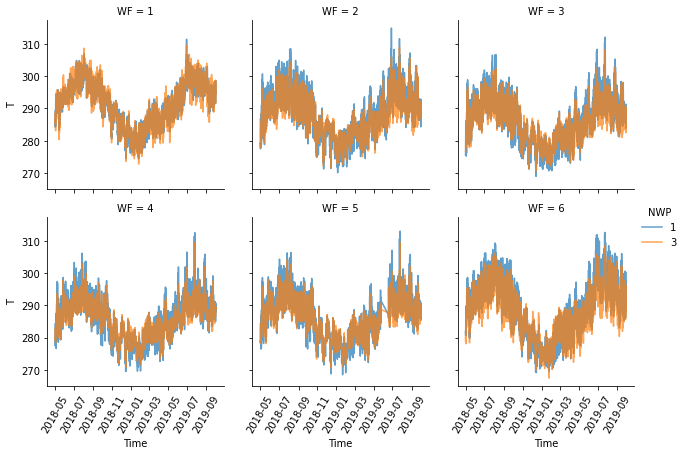

In [10]:
core.plot_feature_vs_time(df_aug,"T") # Try also with T, U, V, CLCT, WS, WD variables

Let's now explore how the power production (target output) evolves in time for each wind farms. We can see that for instance that the maximal power production authorized is reached in WF1 and WF6, and that this limit is different from a wind farm to another (limited at 10 MW for WF1 and at 4 MW for WF6).

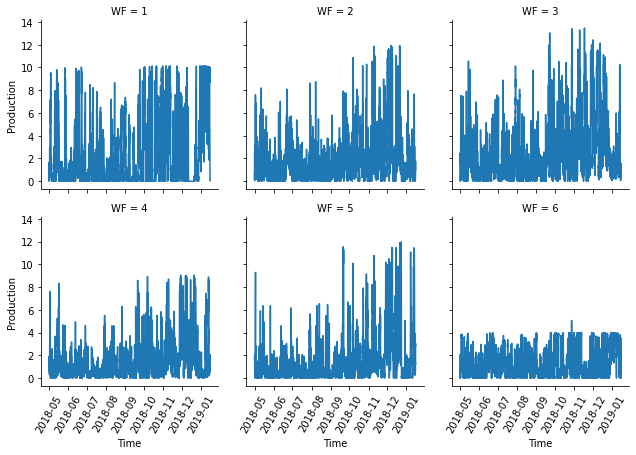

In [12]:
core.plot_production_vs_time(df_aug)

The following correlation graph confirms the high importance of having computed the wind speed *WS*: it is the feature that correlate the most with the power production.

c:\users\qchat\venv\wind-power-forecasting-challenge\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


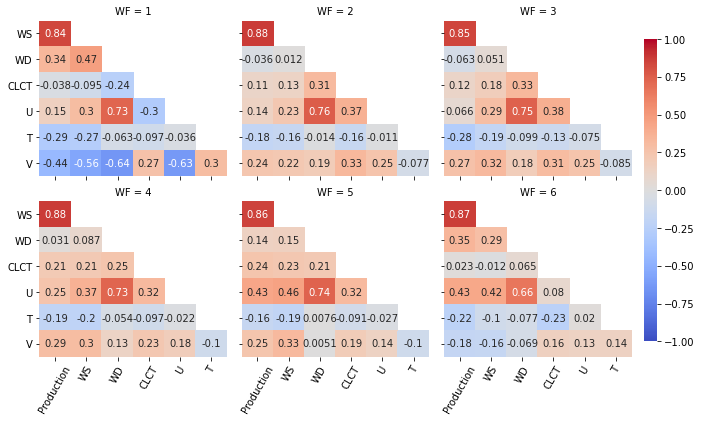

In [13]:
core.plot_correlation_graph(core.mean_data(df_aug))

Furthermore, we can see on the following graph (Production vs WS) that:
 - there is, on average, a linear relationship between the wind speed and power production.
 - the maximal power production capacity is limited differently regarding the wind farms. 
 - WF1 seems to contain a period of forced inactivity (high WS forecasted but 0 MW of power production), which should be excluded from the training set.

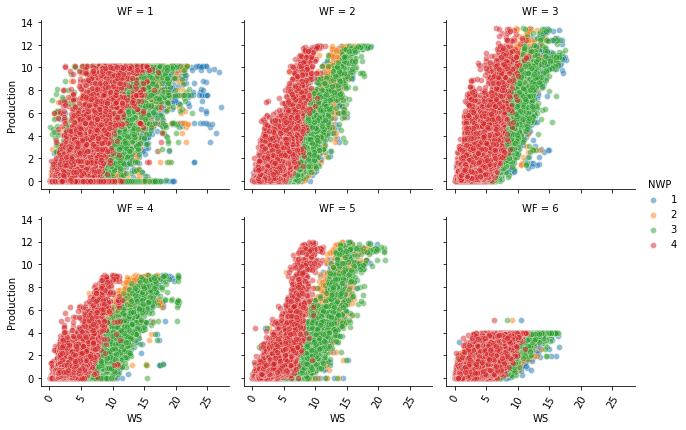

In [14]:
core.plot_feature_vs_production(df_aug,'WS') # Can be tried also with T, U, V, CLCT, WS, WD variables

### Data normalization
- Standard normalization (z-score) for weather variables *U*, *V*, *T*, *WS*, *WD*.
- Rescaling weather variable *CLCT* percentage between 0 and 1.

The power production is not rescaled (values lying in [0,14]).

In [ ]:
# Data normalization
df = core.normalize_data(df_aug)
df.loc[51:54]

# Model

In [ ]:
# Model parameters
WINDOW_SIZE = 72  # In hours
BATCH_SIZE = 2000
EPOCHS = 10
UNITS = 32

In [ ]:
# Training function
def train_model(t_train, x_train, y_train, t_valid, x_valid, y_valid):

    mlflow.log_params({'window_size':WINDOW_SIZE, 'units':UNITS, 'layer_type':'GRU'})
    
    # Make learning datasets
    dataset_train = core.get_windowed_dataset(x_train, y_train, WINDOW_SIZE, BATCH_SIZE, shuffle=True)
    dataset_valid = core.get_windowed_dataset(x_valid, y_valid, WINDOW_SIZE, BATCH_SIZE, shuffle=False) if x_valid is not None else None
        
    # Define model
    model = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape=next(iter(dataset_train))[0].shape[1:]),
                tf.keras.layers.GRU(UNITS, return_sequences=True),
                tf.keras.layers.Dropout(0.6),
                tf.keras.layers.GRU(UNITS, return_sequences=True),
                tf.keras.layers.Dropout(0.6),
                tf.keras.layers.GRU(UNITS),
                tf.keras.layers.Dense(1, activation='relu')
            ])
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam())
    
    # Train model
    history = model.fit(dataset_train, 
                        validation_data=dataset_valid,
                        epochs=EPOCHS,
                        verbose=1, 
                        callbacks=[])#tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001,patience=30)])
    core.plot_learning_curves(history)
    
    # Check predictions
    y_train_predict = core.predict(model, dataset_train, t_train)
    core.plot_predictions(t_train, y_train, y_train_predict, 'train')
    if dataset_valid is not None :
        y_valid_predict = core.predict(model, dataset_valid, t_valid)
        core.plot_predictions(t_valid, y_valid, y_valid_predict, 'valid')
            
    return model, history

# Holdout validation

In [ ]:
HOLDOUT_VAL_SPLIT = 0.85

In [ ]:
# TRAIN ONLY ONE WIND FARM
# ================================
def train_holdout_validation(wf_num, nested_run=False) :

    with mlflow.start_run(nested=nested_run):    
        mlflow.log_params({'wf':wf_num, 'split':HOLDOUT_VAL_SPLIT})

        # Extract wf data
        df_wf = core.extract_wf_data(df, wf_num)
        
        # Train
        t_train, x_train, y_train, t_valid, x_valid, y_valid = core.split_holdout_validation(df_wf, HOLDOUT_VAL_SPLIT, WINDOW_SIZE)
        model, history = train_model(t_train, x_train, y_train, t_valid, x_valid, y_valid)
            
    return model, history    

In [ ]:
# Train one wind farm
mlflow.set_experiment('holdout_validation')
model, history = train_holdout_validation(3)

In [ ]:
# Train all wind farms
mlflow.set_experiment('holdout_validation')
with mlflow.start_run() :
    for wf_num in df.WF.unique(): 
        train_holdout_validation(wf_num, nested_run = True)

# Forward chaining validation

In [ ]:
# Forward chaining parameters
FC_VAL_NB = 4
FC_VAL_SIZE = 0.05

In [ ]:
def train_forward_chaining_validation(wf_num):

    # Extract wf data
    df_wf = core.extract_wf_data(df, wf_num)
    
    # Train models
    metrics = []
    datas = core.split_forward_chaining_validation(df_wf, FC_VAL_SIZE, FC_VAL_NB, WINDOW_SIZE)
    for (t_train, x_train, y_train, t_valid, x_valid, y_valid) in datas :
        with mlflow.start_run(nested=True) :
            model, history = train_model(t_train, x_train, y_train, t_valid, x_valid, y_valid)
            metrics.append(history.history)
    
    # Calculate mean and std errors
    metrics = core.get_mean_std_metrics(metrics)
    mlflow.log_metrics(metrics)

In [ ]:
mlflow.set_experiment('forward_chaining_validation')
for wf_num in df.WF.unique():
    with mlflow.start_run():    
        mlflow.log_params({'wf':wf_num,'valid_size':FC_VAL_SIZE,'nb_valid':FC_VAL_NB, 'nlayers':3, 
                        'layer_type':'GRU','units':UNITS,'epochs':EPOCHS, 'parent':True})
        train_forward_chaining_validation(wf_num)

In [ ]:
wf_num = 4
mlflow.set_experiment('forward_chaining_validation')
for UNITS in [32,64] :
    with mlflow.start_run() :
        mlflow.log_params({'wf':wf_num,'valid_size':FC_VAL_SIZE,'nb_valid':FC_VAL_NB, 'nlayers':1, 
                           'layer_type':'GRU', 'units':UNITS, 'epochs':EPOCHS, 'parent':True })
        train_forward_chaining_validation(wf_num)

# Full training

In [ ]:
# TRAIN ALL WIND FARMS AND PREDICT
# ================================
def train_full(wf_num, nested_run=False) :
    with mlflow.start_run(nested=nested_run): 
        mlflow.log_param('wf',wf_num)

        # Extract data
        df_wf = core.extract_wf_data(df, wf_num)        
        
        # Train model
        t_train, x_train, y_train = core.get_train_dataset(df_wf, WINDOW_SIZE)
        model, history = train_model(t_train, x_train, y_train, None, None, None)

        # Predict on test data
        t_test, x_test = core.get_test_dataset(df_wf, WINDOW_SIZE)
        dataset_test = core.get_windowed_dataset(x_test, None, WINDOW_SIZE, BATCH_SIZE, shuffle=False)
        y_test_predict = core.predict(model, dataset_test, t_test)    
        core.plot_predictions(t_test, None, y_test_predict, 'test')

    return y_test_predict

In [ ]:
mlflow.set_experiment('Full training')
with mlflow.start_run():
    predictions = [train_full(wf_num, nested_run=True) for wf_num in df.WF.unique()]
    core.save_predictions(predictions)